In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
#%matplotlib notebook
%matplotlib inline
import torch.nn as nn, timeit, torch, pystan as ps
from time import time
import matplotlib.pyplot as plt
from pylab import plot, show, legend

In [2]:
sm_refpoints = ps.StanModel(file="stan_files/nn_refpoints.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f58d235465c773e740a890b0262cc7f NOW.


In [3]:
M = 1000
X = 10*npr.rand(2,M)
Y = np.zeros((3,M))
Y[0] = np.cos(X[0])*np.cos(X[1])
Y[1] = np.cos(X[0])*np.sin(X[1])
Y[2] = np.sin(X[0])

idx = Y[2]>0
Y = Y[:,idx]
X = X[:,idx]
Y += 0.1*npr.rand(*np.shape(Y))
Nobs = np.shape(X)[1]

### Local linear embedding for reference points:

In [4]:
n_ref = 0
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [5]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [6]:
n_in = np.shape(Y_embedded)[0]
n_out = np.shape(Y)[0]
n_h = 20

In [7]:
data = dict(Nobs=Nobs, in_dim=np.shape(X)[0], out_dim=np.shape(Y)[0], hidden_dim=n_h,
            n_ref=np.shape(Y_ref)[1], y=Y_train, y_ref=Y_ref, X_ref=X_ref)

### Run Stan:

In [8]:
start = time()
fit = sm_refpoints.sampling(data=data, thin=1, n_jobs=10, chains=10,
                            init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


62.72 minutes to run


In [9]:
trace = fit.extract()
n_samples, n_latent = np.shape(trace['X'])[0], np.shape(trace['X'])[1]

### Traceplots of latent variables:

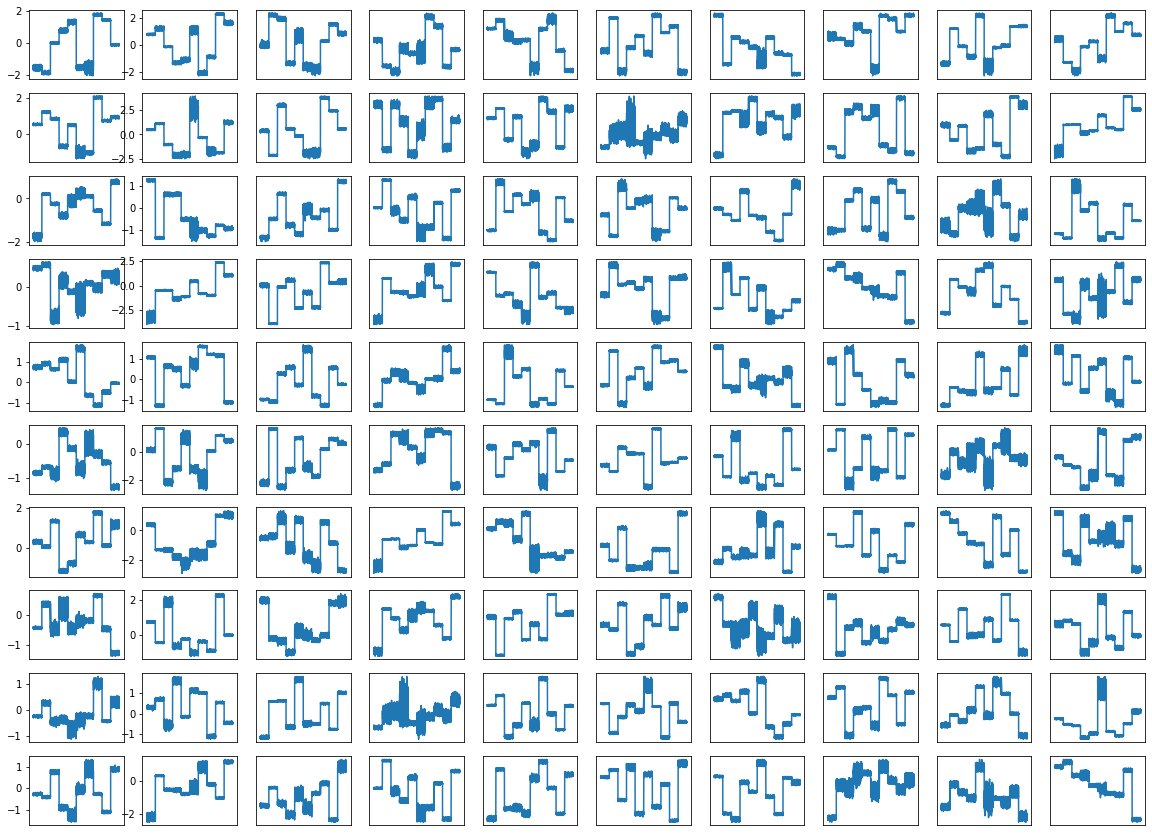

In [10]:
plt.figure(figsize=(20,15))
idx = npr.choice(n_latent,100).reshape(10,10)

for i in range(10):
    for j in range(10):
        k = 10*i+j
        plt.subplot(10,10,k+1)
        plt.plot(trace['X'][:,idx[i,j],0])
        plt.xticks([])
        if j > 1 : plt.yticks([])
plt.show()

### Loss:

In [11]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

100%|██████████| 5000/5000 [00:01<00:00, 3269.49it/s]


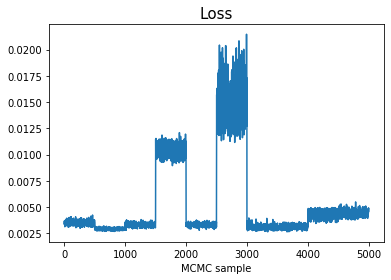

In [12]:
loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace['X'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample");

### Pairwise distances:

In [13]:
pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for i in trange(50) :
    for j in range(50) :
        for k in range(n_samples) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['X'][k,i]-trace['X'][k,j])

100%|██████████| 50/50 [01:02<00:00,  1.26s/it]


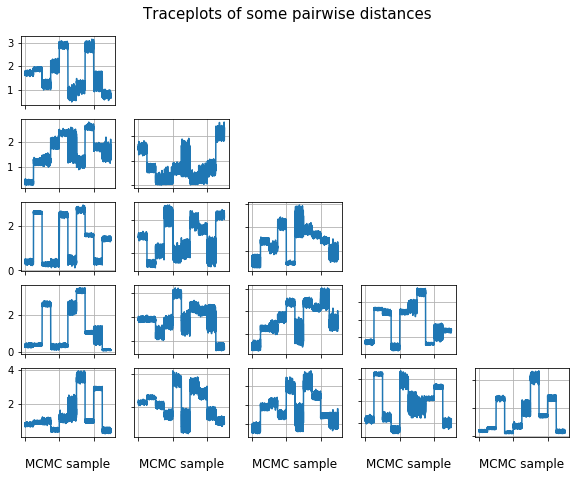

In [25]:
k_max = 50
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 6 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
plt.suptitle("Traceplots of some pairwise distances", fontsize=15, x=0.31,y=0.83)
plt.savefig('plots/pw_dist_unconstrainedW1_norefpoints.pdf', dpi=2000, bbox_inches='tight');